# PaddleCatcher AI Experimentation

This notebook loads the Rust machine learning library and performs experiments on the collected dataset.

In [ ]:
import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setup Plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load Rust Library (FFI)

In [ ]:
# Path to the compiled DLL
dll_path = os.path.join("RustLib", "target", "release", "rust_machine_learning_library.dll")

if not os.path.exists(dll_path):
    # Try looking for .so or .dylib if on other OS (though user is on Windows)
    print(f"Warning: {dll_path} not found.")

lib = ctypes.CDLL(dll_path)

# Define Argument and Return Types
lib.perceptron_new.argtypes = [ctypes.c_int, ctypes.c_float, ctypes.c_bool]
lib.perceptron_new.restype = ctypes.c_void_p

lib.perceptron_predict.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.c_int]
lib.perceptron_predict.restype = ctypes.c_float

lib.perceptron_train.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.c_int, ctypes.c_float]
lib.perceptron_train.restype = None

lib.perceptron_free.argtypes = [ctypes.c_void_p]
lib.perceptron_free.restype = None

In [ ]:
# Hyperparameters
EPOCHS = 500
LEARNING_RATE = 0.001
HIDDEN_NEURONS = 8

## 2. Load and Preprocess Data

In [ ]:
def load_dataset(path, max_balls=3):
    df = pd.read_csv(path)
    
    X = []
    y = []
    
    for _, row in df.iterrows():
        paddle_x = row['PaddleX']
        action_x = row['ActionX']
        balls_str = row['BallsData']
        
        # Parse balls
        balls = []
        if isinstance(balls_str, str) and balls_str.strip():
            for ball_part in balls_str.split('|'):
                if ':' in ball_part:
                    bx, by = map(float, ball_part.split(':'))
                    balls.append((bx, by))
        
        # Sort balls by Y (lowest first - closest to paddle level?)
        # Assuming balls fall from top to bottom, lowest Y is closest to bottom.
        balls.sort(key=lambda b: b[1])
        
        # Construct Input Vector
        # [PaddleX, Ball1X, Ball1Y, Ball2X, Ball2Y, ...]
        features = [paddle_x]
        for i in range(max_balls):
            if i < len(balls):
                features.append(balls[i][0])
                features.append(balls[i][1])
            else:
                features.append(0.0) # Padding X
                features.append(10.0) # Padding Y (far away)
        
        X.append(features)
        y.append(action_x)
        
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = load_dataset('dataset.csv')
print(f"Dataset Loaded. Shape: X={X.shape}, y={y.shape}")

# Split Train/Test
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train set: {len(X_train)}, Test set: {len(X_test)}")

Dataset Loaded. Shape: X=(10094, 7), y=(10094,)
Train set: 8075, Test set: 2019


## 3. Training Loop

In [ ]:
def train_model(X_train, y_train, X_test, y_test, mode='regression', epochs=EPOCHS, alpha=LEARNING_RATE):
    is_classification = (mode == 'classification')
    input_size = X_train.shape[1]
    
    # Create Model
    model = lib.perceptron_new(input_size, alpha, is_classification)
    
    train_errors = []
    test_errors = []
    
    for epoch in range(epochs):
        # Train
        for i in range(len(X_train)):
            inputs = X_train[i]
            target = y_train[i]
            
            # Convert to C types
            c_inputs = inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
            c_len = len(inputs)
            
            lib.perceptron_train(model, c_inputs, c_len, target)
            
        # Evaluate Train
        train_loss = evaluate(model, X_train, y_train, is_classification)
        train_errors.append(train_loss)
        
        # Evaluate Test
        test_loss = evaluate(model, X_test, y_test, is_classification)
        test_errors.append(test_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train={train_loss:.4f}, Test={test_loss:.4f}")
            
    # Free memory
    lib.perceptron_free(model)
    
    return train_errors, test_errors

def evaluate(model, X, y, is_classification):
    total_error = 0.0
    correct = 0
    
    for i in range(len(X)):
        inputs = X[i]
        target = y[i]
        
        c_inputs = inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        c_len = len(inputs)
        
        prediction = lib.perceptron_predict(model, c_inputs, c_len)
        
        if is_classification:
            # Simple sign check for binary classification (-1 vs 1)
            # Assuming target is -1 or 1
            if (prediction > 0 and target > 0) or (prediction < 0 and target < 0):
                correct += 1
        else:
            total_error += (target - prediction) ** 2
            
    if is_classification:
        return 1.0 - (correct / len(X)) # Error rate
    else:
        return total_error / len(X) # MSE

## 4. Experiment 1: Regression

Epoch 0: Train=0.8384, Test=0.8734
Epoch 10: Train=0.8414, Test=0.8792
Epoch 20: Train=0.8407, Test=0.8781
Epoch 30: Train=0.8402, Test=0.8773
Epoch 40: Train=0.8400, Test=0.8768
Epoch 50: Train=0.8398, Test=0.8766
Epoch 60: Train=0.8398, Test=0.8764
Epoch 70: Train=0.8397, Test=0.8763
Epoch 80: Train=0.8397, Test=0.8763
Epoch 90: Train=0.8397, Test=0.8763
Epoch 100: Train=0.8397, Test=0.8763
Epoch 110: Train=0.8397, Test=0.8762
Epoch 120: Train=0.8397, Test=0.8762
Epoch 130: Train=0.8397, Test=0.8762
Epoch 140: Train=0.8397, Test=0.8762
Epoch 150: Train=0.8397, Test=0.8762
Epoch 160: Train=0.8397, Test=0.8762
Epoch 170: Train=0.8397, Test=0.8762
Epoch 180: Train=0.8397, Test=0.8762
Epoch 190: Train=0.8397, Test=0.8762
Epoch 200: Train=0.8397, Test=0.8762
Epoch 210: Train=0.8397, Test=0.8762
Epoch 220: Train=0.8397, Test=0.8762
Epoch 230: Train=0.8397, Test=0.8762
Epoch 240: Train=0.8397, Test=0.8762
Epoch 250: Train=0.8397, Test=0.8762
Epoch 260: Train=0.8397, Test=0.8762
Epoch 270: T

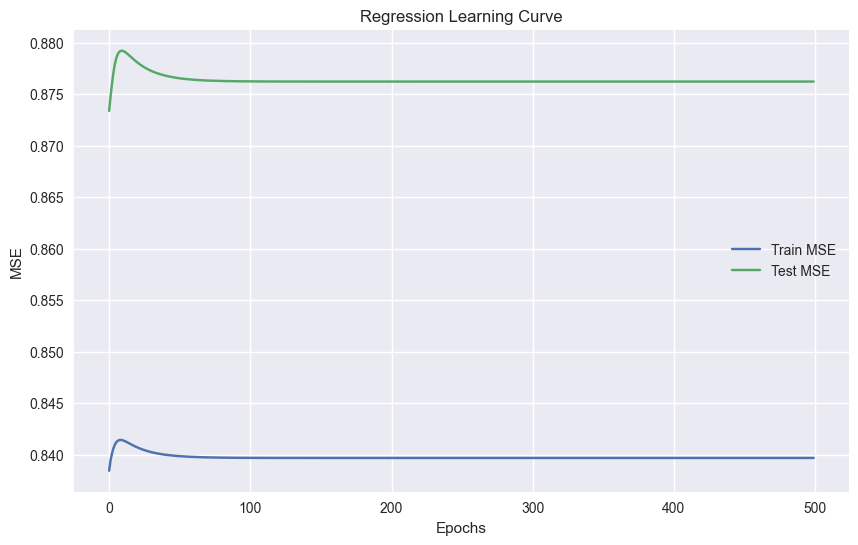

In [ ]:
train_err, test_err = train_model(X_train, y_train, X_test, y_test, mode='regression', epochs=EPOCHS, alpha=LEARNING_RATE)

plt.figure()
plt.plot(train_err, label='Train MSE')
plt.plot(test_err, label='Test MSE')
plt.title('Regression Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('regressionon_learning_curve.png')
plt.show()

## 5. Experiment 2: Classification

Epoch 0: Train=0.1958, Test=0.1862
Epoch 10: Train=0.1953, Test=0.1857
Epoch 20: Train=0.1895, Test=0.1838
Epoch 30: Train=0.1838, Test=0.1798
Epoch 40: Train=0.1911, Test=0.1842
Epoch 50: Train=0.1946, Test=0.1867
Epoch 60: Train=0.1890, Test=0.1857
Epoch 70: Train=0.1897, Test=0.1838
Epoch 80: Train=0.1998, Test=0.1892
Epoch 90: Train=0.1900, Test=0.1838
Epoch 100: Train=0.1928, Test=0.1842
Epoch 110: Train=0.1759, Test=0.1719
Epoch 120: Train=0.1957, Test=0.1852
Epoch 130: Train=0.1837, Test=0.1753
Epoch 140: Train=0.1967, Test=0.1887
Epoch 150: Train=0.1897, Test=0.1852
Epoch 160: Train=0.1901, Test=0.1847
Epoch 170: Train=0.1920, Test=0.1847
Epoch 180: Train=0.1761, Test=0.1714
Epoch 190: Train=0.1965, Test=0.1842
Epoch 200: Train=0.1889, Test=0.1828
Epoch 210: Train=0.1865, Test=0.1808
Epoch 220: Train=0.1989, Test=0.1867
Epoch 230: Train=0.1936, Test=0.1847
Epoch 240: Train=0.1897, Test=0.1833
Epoch 250: Train=0.1869, Test=0.1778
Epoch 260: Train=0.1830, Test=0.1823
Epoch 270: T

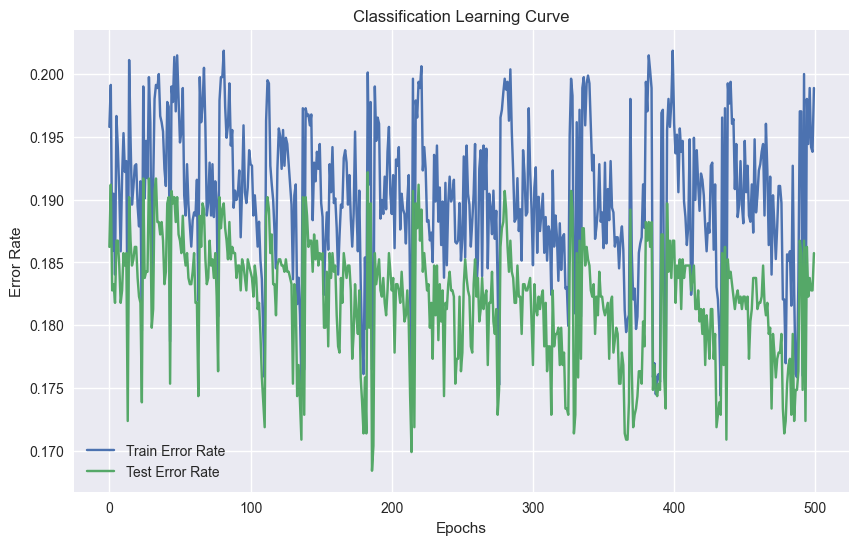

In [ ]:
# Prepare Classification Targets (Thresholding)
# If action < -0.1 -> -1, if action > 0.1 -> 1, else 0 (ignore or treat as class?)
# Perceptron simple is binary (-1, 1). Let's filter out 'stay' actions or map them.
# For this experiment, let's map >0 to 1 and <=0 to -1.

y_train_cls = np.where(y_train > 0, 1.0, -1.0).astype(np.float32)
y_test_cls = np.where(y_test > 0, 1.0, -1.0).astype(np.float32)

train_err_cls, test_err_cls = train_model(X_train, y_train_cls, X_test, y_test_cls, mode='classification', epochs=EPOCHS, alpha=LEARNING_RATE)

plt.figure()
plt.plot(train_err_cls, label='Train Error Rate')
plt.plot(test_err_cls, label='Test Error Rate')
plt.title('Classification Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.savefig('classification_learning_curve.png')
plt.legend()
plt.show()

## 6. MLP Implementation and Experiments

We will now extend our experimentation to a Multi-Layer Perceptron (MLP) to capture non-linear relationships.

In [ ]:
# Define FFI for MLP
lib.mlp_new.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t]
lib.mlp_new.restype = ctypes.c_void_p

lib.mlp_predict.argtypes = [
    ctypes.c_void_p, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int, 
    ctypes.c_bool, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int
]
lib.mlp_predict.restype = None

lib.mlp_train.argtypes = [
    ctypes.c_void_p, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int, 
    ctypes.POINTER(ctypes.c_float), ctypes.c_int, 
    ctypes.c_bool, 
    ctypes.c_float
]
lib.mlp_train.restype = None

lib.mlp_free.argtypes = [ctypes.c_void_p]
lib.mlp_free.restype = None

In [ ]:
# Update evaluate and train_model functions to support MLP
def evaluate(model, X, y, is_classification, is_mlp=False):
    total_error = 0.0
    correct = 0
    
    for i in range(len(X)):
        inputs = X[i]
        target = y[i]
        
        c_inputs = inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        c_len = len(inputs)
        
        if is_mlp:
            output = np.zeros(1, dtype=np.float32)
            c_output = output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
            lib.mlp_predict(model, c_inputs, c_len, is_classification, c_output, 1)
            prediction = output[0]
        else:
            prediction = lib.perceptron_predict(model, c_inputs, c_len)
        
        if is_classification:
            if (prediction > 0 and target > 0) or (prediction < 0 and target < 0):
                correct += 1
        else:
            total_error += (target - prediction) ** 2
            
    if is_classification:
        return 1.0 - (correct / len(X)) # Error rate
    else:
        return total_error / len(X) # MSE

def train_model(X_train, y_train, X_test, y_test, mode='regression', epochs=EPOCHS, alpha=LEARNING_RATE, use_mlp=False):
    is_classification = (mode == 'classification')
    input_size = X_train.shape[1]
    
    # Create Model
    if use_mlp:
        # Architecture: Input -> 8 -> 1
        layers = np.array([input_size, HIDDEN_NEURONS, 1], dtype=np.uint64) # usize is 64-bit on 64-bit systems
        c_layers = layers.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
        model = lib.mlp_new(c_layers, len(layers))
    else:
        model = lib.perceptron_new(input_size, alpha, is_classification)
    
    train_errors = []
    test_errors = []
    
    for epoch in range(epochs):
        # Train
        for i in range(len(X_train)):
            inputs = X_train[i]
            target = y_train[i]
            
            c_inputs = inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
            c_len = len(inputs)
            
            if use_mlp:
                # MLP expects array of outputs
                target_arr = np.array([target], dtype=np.float32)
                c_target = target_arr.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
                lib.mlp_train(model, c_inputs, c_len, c_target, 1, is_classification, alpha)
            else:
                lib.perceptron_train(model, c_inputs, c_len, target)
            
        # Evaluate Train
        train_loss = evaluate(model, X_train, y_train, is_classification, is_mlp=use_mlp)
        train_errors.append(train_loss)
        
        # Evaluate Test
        test_loss = evaluate(model, X_test, y_test, is_classification, is_mlp=use_mlp)
        test_errors.append(test_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train={train_loss:.4f}, Test={test_loss:.4f}")
            
    # Free memory
    if use_mlp:
        lib.mlp_free(model)
    else:
        lib.perceptron_free(model)
    
    return train_errors, test_errors

### 6.1 MLP Regression

Starting Regression Experiment (MLP)...
Epoch 0: Train=0.4170, Test=0.4114
Epoch 10: Train=0.2390, Test=0.2413
Epoch 20: Train=0.2407, Test=0.2465
Epoch 30: Train=0.2390, Test=0.2527
Epoch 40: Train=0.2769, Test=0.2990
Epoch 50: Train=0.2687, Test=0.2899
Epoch 60: Train=0.2660, Test=0.2869
Epoch 70: Train=0.2658, Test=0.2848
Epoch 80: Train=0.2647, Test=0.2819
Epoch 90: Train=0.2639, Test=0.2796
Epoch 100: Train=0.2643, Test=0.2795
Epoch 110: Train=0.2652, Test=0.2800
Epoch 120: Train=0.2661, Test=0.2807
Epoch 130: Train=0.2669, Test=0.2813
Epoch 140: Train=0.2676, Test=0.2818
Epoch 150: Train=0.2681, Test=0.2823
Epoch 160: Train=0.2685, Test=0.2826
Epoch 170: Train=0.2689, Test=0.2829
Epoch 180: Train=0.2692, Test=0.2831
Epoch 190: Train=0.2694, Test=0.2833
Epoch 200: Train=0.2696, Test=0.2835
Epoch 210: Train=0.2697, Test=0.2836
Epoch 220: Train=0.2698, Test=0.2836
Epoch 230: Train=0.2698, Test=0.2837
Epoch 240: Train=0.2699, Test=0.2837
Epoch 250: Train=0.2699, Test=0.2838
Epoch 260

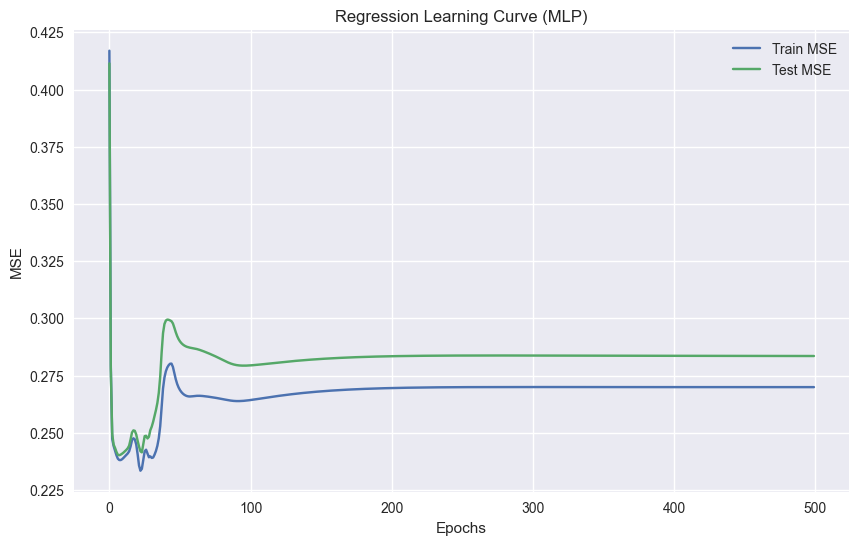

In [ ]:
print("Starting Regression Experiment (MLP)...")
train_err_mlp, test_err_mlp = train_model(X_train, y_train, X_test, y_test, mode='regression', epochs=EPOCHS, alpha=LEARNING_RATE, use_mlp=True)

plt.figure()
plt.plot(train_err_mlp, label='Train MSE')
plt.plot(test_err_mlp, label='Test MSE')
plt.title('Regression Learning Curve (MLP)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('mlp_regression_learning_curve.png')
plt.show()

### 6.2 MLP Classification

Starting Classification Experiment (MLP)...
Epoch 0: Train=0.2152, Test=0.1966
Epoch 10: Train=0.1481, Test=0.1555
Epoch 20: Train=0.1479, Test=0.1743
Epoch 30: Train=0.1441, Test=0.1649
Epoch 40: Train=0.1419, Test=0.1585
Epoch 50: Train=0.1538, Test=0.1649
Epoch 60: Train=0.1760, Test=0.1634
Epoch 70: Train=0.1716, Test=0.1620
Epoch 80: Train=0.1657, Test=0.1634
Epoch 90: Train=0.1621, Test=0.1630
Epoch 100: Train=0.1615, Test=0.1630
Epoch 110: Train=0.1583, Test=0.1615
Epoch 120: Train=0.1568, Test=0.1620
Epoch 130: Train=0.1559, Test=0.1620
Epoch 140: Train=0.1558, Test=0.1620
Epoch 150: Train=0.1557, Test=0.1620
Epoch 160: Train=0.1557, Test=0.1615
Epoch 170: Train=0.1557, Test=0.1615
Epoch 180: Train=0.1555, Test=0.1615
Epoch 190: Train=0.1558, Test=0.1615
Epoch 200: Train=0.1559, Test=0.1615
Epoch 210: Train=0.1560, Test=0.1615
Epoch 220: Train=0.1560, Test=0.1615
Epoch 230: Train=0.1562, Test=0.1625
Epoch 240: Train=0.1562, Test=0.1634
Epoch 250: Train=0.1563, Test=0.1639
Epoch

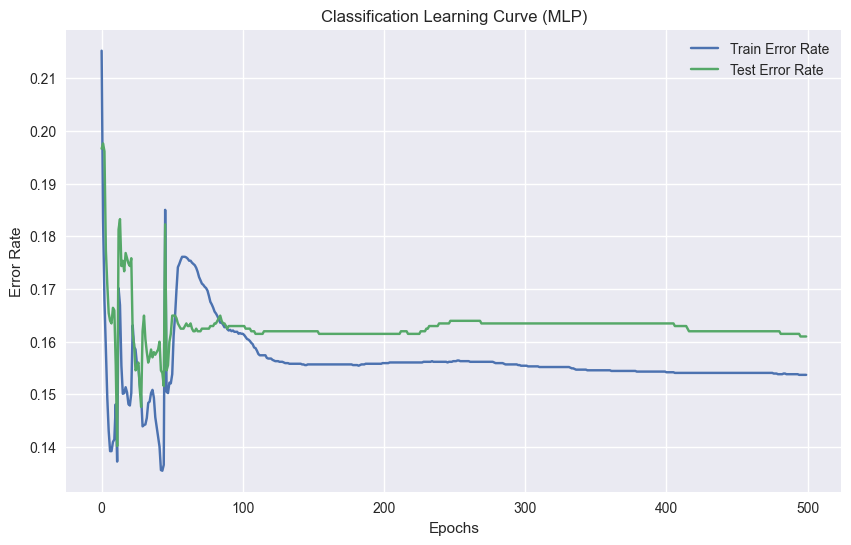

: 

In [ ]:
print("Starting Classification Experiment (MLP)...")
train_err_mlp_cls, test_err_mlp_cls = train_model(X_train, y_train_cls, X_test, y_test_cls, mode='classification', epochs=EPOCHS, alpha=LEARNING_RATE, use_mlp=True)

plt.figure()
plt.plot(train_err_mlp_cls, label='Train Error Rate')
plt.plot(test_err_mlp_cls, label='Test Error Rate')
plt.title('Classification Learning Curve (MLP)')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.savefig('mlp_classification_learning_curve.png')
plt.show()